In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn 
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
import statsmodels.formula.api as smf

In [49]:
def split_variables(data):
    categorical_vars = []
    numerical_vars = []

    for column in data.columns:
        if "is_" in column:
            categorical_vars.append(column)
        else:
            numerical_vars.append(column)

    return categorical_vars, numerical_vars

def Vif_Examiner(data):
    issue = []
    for i in range(0,10):
        vif=variance_inflation_factor(data, i)
        if vif>=5:
            issue.append(i)
    return issue

def add_prefix_to_columns(df, prefix):
    new_columns = [df.columns[0]] + [prefix + col for col in df.columns[1:]]
    df.columns = new_columns
    return df

def check_skewness(data):
    
    skewness = np.mean((data - np.mean(data))**3) / np.power(np.var(data), 3/2)

    if skewness < -1:
        return -1 #left
    elif skewness > 1:
        return 1 #right
    else:
        return 0 #normal
    
def process_columns(df):
    # 获取从第四列开始的所有列
    columns_to_process = df.columns[3:]
    right_skewed = []
    left_skewed = []
    # check skewness
    for column in columns_to_process:
        result = check_skewness(df[column])
        if result == 1:
            right_skewed.append(column)
            continue
        if result == -1:
            left_skewed.append(column)
    return right_skewed,left_skewed


def stepwise_selection(data, target):
    variate = set(data.columns)
    variate.remove(target)
    selected = []
    n = data.shape[0]
    current_score, best_new_score = float('inf'), float('inf')

    while variate or selected:
        forward_candidate, backward_candidate = None, None
        best_backward_score = float('inf')
        # Forward step
        if variate:
            forward_aic_with_variate = []
            for candidate in variate:
                formula = "{}~{}".format(target, "+".join(selected + [candidate]))
                K = formula.count('+')+1
                if n/K < 40:
                    aic = smf.ols(formula=formula, data=data).fit().aic+ 2*K*(K+1)/(n-K-1)
                else:
                    aic = smf.ols(formula=formula, data=data).fit().aic
                forward_aic_with_variate.append((aic, candidate))
            forward_aic_with_variate.sort(reverse=True)
            best_forward_score, forward_candidate = forward_aic_with_variate.pop()
        # Backward step
        if len(selected) > 1:
            backward_aic_with_variate = []
            for candidate in selected:
                selected_new = selected.copy()
                selected_new.remove(candidate)
                formula = "{}~{}".format(target, "+".join(selected_new))
                K = formula.count('+')+1
                if n/K < 40:
                    aic = smf.ols(formula=formula, data=data).fit().aic+ 2*K*(K+1)/(n-K-1)
                else:
                    aic = smf.ols(formula=formula, data=data).fit().aic
                backward_aic_with_variate.append((aic, candidate))
            backward_aic_with_variate.sort(reverse=True)
            best_backward_score, backward_candidate = backward_aic_with_variate.pop()

        # Compare
        if (forward_candidate is not None and best_forward_score < current_score) or \
           (backward_candidate is not None and best_backward_score < current_score):
            if best_forward_score <= best_backward_score:
                variate.remove(forward_candidate)
                selected.append(forward_candidate)
                current_score = best_forward_score
                print('continue,best aic is{}',current_score)
            else:
                selected.remove(backward_candidate)
                current_score = best_backward_score
                print('continue,best aic is{}',current_score)
        else:
            break

    formula = "{}~{}".format(target, "+".join(selected))
    model = smf.ols(formula=formula, data=data).fit()

    return model,selected



In [40]:
path = './data/brain/Train/'
fulldata = pd.read_csv(os.path.join(path,'subject_info - 1600.csv')).iloc[:,:-1]
for file in os.listdir(path):
    if 'subject_info' in file:
        continue
    temp = add_prefix_to_columns(pd.read_csv(os.path.join(path,file)),file.split('-')[0])
    fulldata = pd.merge(fulldata, temp, on='subject_ID', how='inner')
fulldata.drop(['MRI扫描仪类型','subject_ID'],axis=1,inplace=True)
fulldata.rename(columns={'性别': 'sex', '年龄': 'age'}, inplace=True)
fulldata.columns = fulldata.columns.str.replace(' ', '')
fulldata.columns = fulldata.columns.str.replace('.', '')
fulldata.columns = fulldata.columns.str.replace('-', '')
fulldata

/home/weilinda/miniconda3/envs/ofa/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # This is added back by InteractiveShellApp.init_path()


,sex,age,wmparcwmlhbankssts,wmparcwmlhcaudalanteriorcingulate,wmparcwmlhcaudalmiddlefrontal,wmparcwmlhcuneus,wmparcwmlhentorhinal,wmparcwmlhfusiform,wmparcwmlhinferiorparietal,wmparcwmlhinferiortemporal,...,rhGausCurvprecentral,rhGausCurvprecuneus,rhGausCurvrostralanteriorcingulate,rhGausCurvrostralmiddlefrontal,rhGausCurvsuperiorfrontal,rhGausCurvsuperiorparietal,rhGausCurvsuperiortemporal,rhGausCurvsupramarginal,rhGausCurvtransversetemporal,rhGausCurvinsula
0,2,25,2401.1,1887.8,7730.7,3174.8,652.2,6997.8,9180.7,5888.5,...,4870,3895,792,3429,8169,4072,4966,3453,356,1987
1,1,26,2236.6,2041.8,5735.7,2080.4,494.2,5334.0,8885.2,4370.8,...,4120,4187,627,3026,7022,3727,3905,3119,326,1830
2,2,27,3725.3,2417.2,7204.6,2879.0,889.7,7162.9,11511.0,8157.2,...,5537,3892,979,4332,10448,4437,5390,3874,403,2380
3,2,32,3614.6,2936.4,6269.4,3402.1,954.8,7135.5,10941.9,7832.2,...,5852,4924,818,4421,9437,4259,5906,3980,400,2368
4,2,32,2999.8,1894.5,6517.6,3659.5,1061.2,6319.1,11548.2,8460.8,...,4570,4198,779,3322,8125,4571,4657,3690,363,2287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,1,26,2817.2,2839.5,7437.6,3398.3,997.6,6915.1,10307.3,5983.0,...,4617,4758,774,3518,8101,5367,4722,3697,320,1998
1592,1,39,2942.7,2281.9,6973.4,3141.5,642.0,6147.9,9930.5,5936.5,...,4584,4136,809,3851,7651,4466,4395,3066,318,1909
1593,1,36,2493.1,2754.5,6579.3,3220.2,894.4,6736.5,10710.5,7081.4,...,4688,4321,841,3850,8448,4472,4837,3077,369,2048
1594,2,21,2955.3,2274.0,8463.3,3317.1,1011.3,7558.3,11107.6,7499.6,...,6218,4632,908,5596,11140,4896,5738,4054,373,2193


In [14]:
sub_df = fulldata[['age'] + [col for col in fulldata.columns if ('caudalanteriorcingulate' in col)]]
sub_df

,age,wmparc wm-lh-caudalanteriorcingulate,wmparc wm-rh-caudalanteriorcingulate,rh.GrayVolcaudalanteriorcingulate,lh.SurfArea caudalanteriorcingulate,rh.SurfArea caudalanteriorcingulate,rh.MeanCurvcaudalanteriorcingulate,rh.ThickAvgcaudalanteriorcingulate,lh.ThickAvg caudalanteriorcingulate,lh.MeanCurv caudalanteriorcingulate,lh.GrayVol caudalanteriorcingulate,lh.GausCurv caudalanteriorcingulate,rh.GausCurvcaudalanteriorcingulate
0,25,1887.8,2627.1,1923,672,713,0.128,2.430,3.018,0.119,1937,672,713
1,26,2041.8,2193.7,1656,764,512,0.122,2.965,3.075,0.105,2368,764,512
2,27,2417.2,2893.4,2269,1022,773,0.120,2.628,2.477,0.130,2964,1022,773
3,32,2936.4,2558.5,2078,1196,735,0.114,2.439,2.694,0.123,3317,1196,735
4,32,1894.5,2364.9,2039,772,712,0.125,2.540,2.649,0.107,2137,772,712
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,26,2839.5,2802.4,2216,998,744,0.127,2.807,2.850,0.123,3179,998,744
1592,39,2281.9,3204.0,2476,924,899,0.113,2.309,2.719,0.113,2764,924,899
1593,36,2754.5,2837.2,2577,1161,875,0.134,2.470,2.483,0.116,3110,1161,875
1594,21,2274.0,3527.2,3249,1195,1053,0.142,2.492,2.717,0.107,3891,1195,1053


/home/weilinda/miniconda3/envs/ofa/lib/python3.7/site-packages/seaborn/utils.py:80: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.draw()
/home/weilinda/miniconda3/envs/ofa/lib/python3.7/site-packages/seaborn/utils.py:80: UserWarning: Glyph 40836 (\N{CJK UNIFIED IDEOGRAPH-9F84}) missing from current font.
  fig.canvas.draw()
/home/weilinda/miniconda3/envs/ofa/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/weilinda/miniconda3/envs/ofa/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40836 (\N{CJK UNIFIED IDEOGRAPH-9F84}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


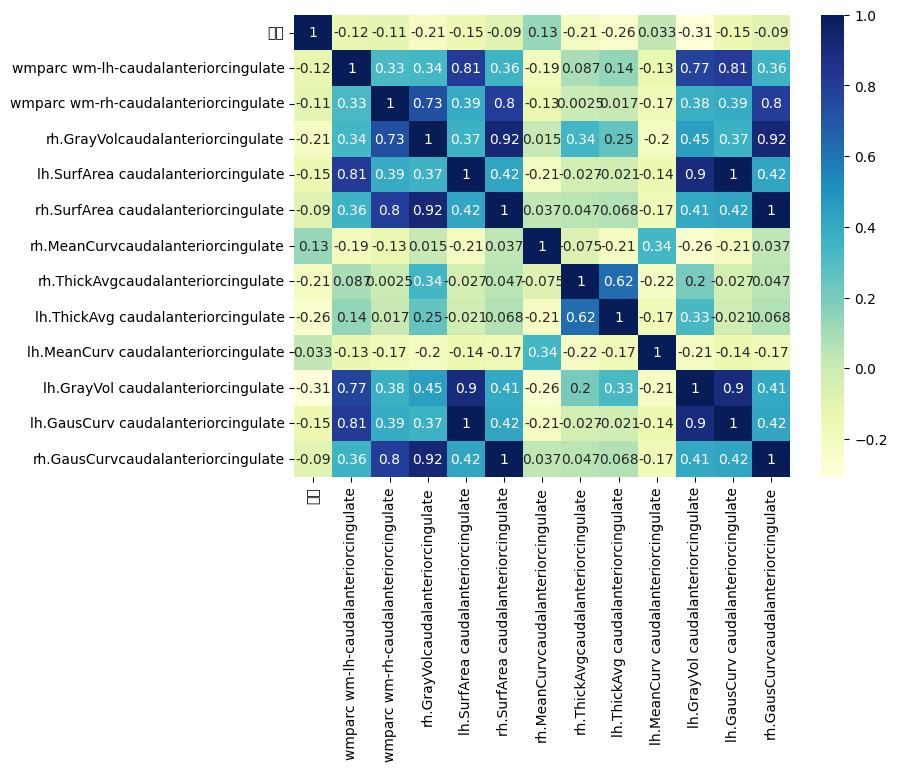

In [6]:
plt.figure(figsize=(8, 6))
sns.heatmap(sub_df.corr(),annot=True, cmap='YlGnBu')
plt.show()

In [50]:
model_try = stepwise_selection(fulldata,'age')

continue,best aic is{} 12506.10846921119
continue,best aic is{} 12402.402184128066
continue,best aic is{} 12257.39706560651
continue,best aic is{} 12181.377376734386
continue,best aic is{} 11990.93346016366
continue,best aic is{} 11894.33022253595
continue,best aic is{} 11827.710799485309
continue,best aic is{} 11768.286884863654
continue,best aic is{} 11727.022067549562
continue,best aic is{} 11677.38493556179
continue,best aic is{} 11623.525260845074
continue,best aic is{} 11577.760183462244
continue,best aic is{} 11527.66590421496
continue,best aic is{} 11489.003437787249
continue,best aic is{} 11461.009699237788
continue,best aic is{} 11433.379055973077
continue,best aic is{} 11393.482836151868
continue,best aic is{} 11367.653464458504
continue,best aic is{} 11326.534116316489
continue,best aic is{} 11307.641834001242
continue,best aic is{} 11293.45027699758
continue,best aic is{} 11277.889181288603
continue,best aic is{} 11261.737775886731
continue,best aic is{} 11248.910300319367

In [7]:
# 将第一列设置为响应变量
response = fulldata.iloc[:, 3]

# 将剩余所有列设置为预测变量（自变量）
predictors = fulldata.iloc[:, 4:]

# 添加截距列
predictors = sm.add_constant(predictors)

# 构建线性回归模型
model = sm.OLS(response, predictors)

# 拟合模型
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     年龄   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     14.44
Date:                Mon, 10 Jul 2023   Prob (F-statistic):          1.22e-274
Time:                        23:50:28   Log-Likelihood:                -5146.5
No. Observations:                1596   AIC:                         1.099e+04
Df Residuals:                    1250   BIC:                         1.284e+04
Df Model:                         345                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    27.4192     27.381      1.001      0.317     -26.300      81.138
wmparc wm-lh-bankssts                    -0.0002      0.001     -0.466      0.642      -0.001       0.001
wmparc wm-lh-caudalanteriorcingulate      0.0016      0.001      1.810      0.070      -0.000       0.003
wmparc wm-lh-caudalmiddlefrontal          0.0007      0.001      1.098      0.272      -0.001       0.002
wmparc wm-lh-cuneus                      -0.0018      0.001     -1.469      0.142      -0.004       0.001
wmparc wm-lh-entorhinal                  -0.0009      0.002     -0.509      0.611      -0.004       0.003
wmparc wm-lh-fusiform                    -0.0002      0.001     -0.251      0.802      -0.001       0.001
wmparc wm-lh-inferiorparietal             0.0001      0.000      0.231      0.817      -0.001       0.001
wmparc wm-lh-inferiortemporal            -0.0003      0.001     -0.449      0.654      -0.001       0.001
wmparc wm-lh-isthmuscingulate             0.0012      0.001      1.016      0.310      -0.001       0.004
wmparc wm-lh-lateraloccipital             0.0003      0.001      0.549      0.583      -0.001       0.001
wmparc wm-lh-lateralorbitofrontal         0.0015      0.001      1.646      0.100      -0.000       0.003
wmparc wm-lh-lingual                      0.0006      0.001      0.829      0.407      -0.001       0.002
wmparc wm-lh-medialorbitofrontal          0.0019      0.001      3.026      0.003       0.001       0.003
wmparc wm-lh-middletemporal              -0.0006      0.001     -1.005      0.315      -0.002       0.001
wmparc wm-lh-parahippocampal          -5.119e-05      0.002     -0.023      0.982      -0.004       0.004
wmparc wm-lh-paracentral                 -0.0005      0.001     -0.539      0.590      -0.002       0.001
wmparc wm-lh-parsopercularis              0.0004      0.001      0.389      0.698      -0.002       0.003
wmparc wm-lh-parsorbitalis                0.0012      0.002      0.591      0.555      -0.003       0.005
wmparc wm-lh-parstriangularis             0.0008      0.001      0.696      0.487      -0.001       0.003
wmparc wm-lh-pericalcarine                0.0007      0.001      0.715      0.475      -0.001       0.002
wmparc wm-lh-postcentral                  0.0002      0.001      0.306      0.759      -0.001       0.001
wmparc wm-lh-posteriorcingulate          -0.0002      0.001     -0.254      0.799      -0.002       0.002
wmparc wm-lh-precentral                   0.0005      0.000      1.113      0.266      -0.000       0.001
wmparc wm-lh-precuneus                    0.0002      0.001      0.388      0.698      -0.001       0.001
wmparc wm-lh-rostralanteriorcingulate     0.0017      0.001      1.941      0.052   -1.78e-05       0.003
wmparc wm

In [8]:
right_skewed,left_skewed = process_columns(fulldata)
right_skewed


['wmparc wm-lh-parahippocampal',
 'wmparc wm-lh-parsorbitalis',
 'wmparc wm-lh-posteriorcingulate',
 'wmparc wm-lh-rostralanteriorcingulate',
 'wmparc wm-lh-frontalpole',
 'wmparc wm-lh-transversetemporal',
 'wmparc wm-rh-entorhinal',
 'wmparc wm-rh-isthmuscingulate',
 'wmparc wm-rh-parahippocampal',
 'wmparc wm-rh-parsorbitalis',
 'wmparc wm-rh-posteriorcingulate',
 'wmparc wm-rh-rostralanteriorcingulate',
 'wmparc wm-rh-frontalpole',
 'wmparc wm-rh-temporalpole',
 'wmparc wm-rh-transversetemporal',
 'wmparc wm-rh-insula',
 'wmparc Left-UnsegmentedWhiteMatter',
 'wmparc Right-UnsegmentedWhiteMatter',
 'rh.GrayVolrostralanteriorcingulate',
 'lh.SurfArea parahippocampal',
 'lh.SurfArea transversetemporal',
 'aseg Left-Cerebellum-White-Matter',
 'aseg CC_Mid_Posterior',
 'rh.SurfArea entorhinal',
 'rh.SurfArea isthmuscingulate',
 'rh.SurfArea medialorbitofrontal',
 'rh.SurfArea rostralanteriorcingulate',
 'rh.MeanCurvcaudalanteriorcingulate',
 'rh.MeanCurvfusiform',
 'rh.MeanCurvinferior

<AxesSubplot:xlabel='rh.GausCurventorhinal', ylabel='Count'>

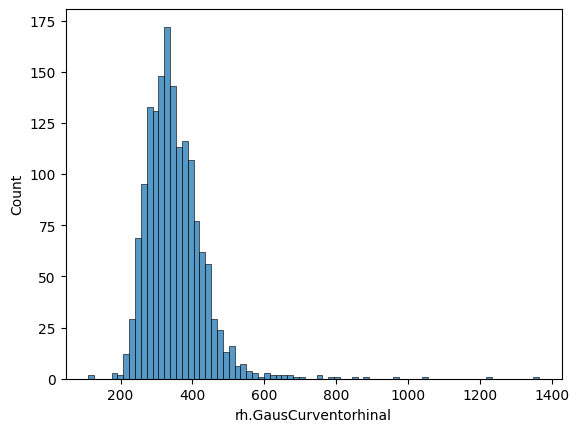

In [9]:
sns.histplot(data=fulldata,x='rh.GausCurventorhinal')